In [45]:
import numpy as np
import cv2
import os 
import matplotlib.pyplot as plt

In [46]:
def load_partial(folder, height, batchsize, overlap):
    lowerh = 0
    upperh = batchsize
    partial = []
    while(height-upperh > batchsize):
        p = np.load(os.path.join(folder, str(lowerh)+'to'+str(upperh)) + '.npy')
        partial.append(p)
        lowerh = upperh - overlap
        upperh = lowerh + batchsize
    p = np.load(os.path.join(folder, str(lowerh)+'to'+str(height)) + '.npy')
    partial.append(p)
    return partial

def stitch(partial, height, batchsize, overlap):
    lowerh = 0
    upperh = batchsize
    full = np.full((height, partial[0].shape[1]), -1)
    hoverlap = overlap/2
    i = 0
    while(height-upperh > batchsize):
        # print(lowerh, upperh)
        if(lowerh==0):
            full[int(lowerh):int(upperh-hoverlap)] = partial[i][0:int(batchsize-hoverlap)]
        else:
            full[int(lowerh+hoverlap):int(upperh-hoverlap)] = partial[i][int(hoverlap):int(batchsize-hoverlap)]
        lowerh = upperh - overlap
        upperh = lowerh + batchsize
        i+=1
    full[int(lowerh+hoverlap):] = partial[i][int(hoverlap):]
    return full

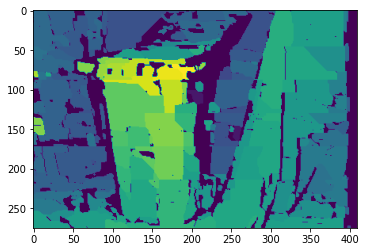

In [47]:
partial3 = load_partial('run', 275, 50, 8)
full3 = stitch(partial3, 275, 50, 8)
plt.imshow(full3)
plt.show()

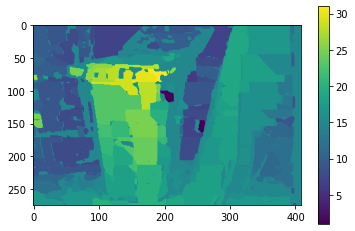

In [48]:
image = plt.imread('Data\Recycle-perfect\im1.png')
disp_map = full3.copy()
disp_map[disp_map < 0] = np.average(disp_map[disp_map >= 0])
plt.imshow(disp_map)
plt.colorbar()
plt.show()

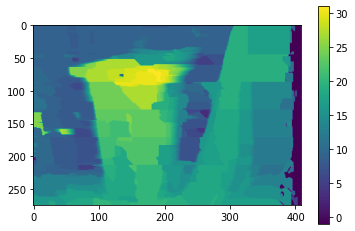

In [75]:
disp_reg = np.load('full.npy')
plt.imshow(disp_reg)
plt.colorbar()
plt.show()

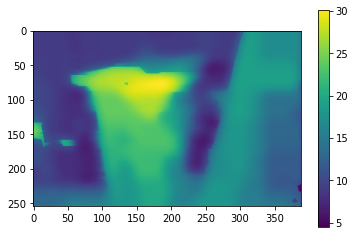

In [162]:
disp_bilat = cv2.bilateralFilter(disp_reg.astype(np.float32), 0, 10, 10)
disp_bilat = disp_bilat[:-20, :-20]
plt.imshow(disp_bilat)
plt.colorbar()
plt.show()

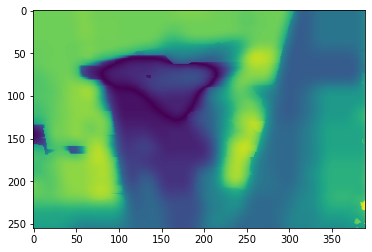

[4.48226929e-04 2.00044823e+00 4.00044823e+00 6.00044823e+00
 8.00044823e+00 1.00004482e+01 1.20004482e+01 1.40004482e+01
 1.60004482e+01 1.80004482e+01 2.00004482e+01 2.05146561e+01]


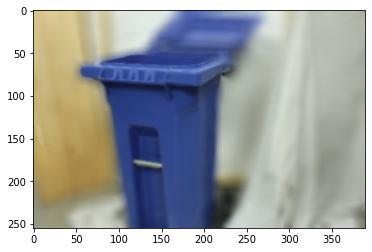

In [170]:
def dof_blur(color_image, disparity_map, disp_in_focus, levels=10, blurrness=1):
    # Simulate depth of field effect
    # 
    # Inputs:
    # color_image - the rgb image to apply dof effect on
    # disparity_map - the disparity map of the rgb image, 
    #                 should be aligned with the rgb image
    # disp_in_focus - the disparity of the plane in focus
    # levels - the number of disparity ranges to consider
    # blurrness - how strong the blurrness is if not in focus
    # 
    # Output:
    # Blurred image simulating depth of field effect

    h, w = color_image.shape[:2]
    disp_to_focus_map = np.abs(disparity_map - disp_in_focus)
    plt.imshow(disp_to_focus_map / np.max(disp_to_focus_map))
    plt.show()
    disp_min = np.min(disp_to_focus_map)
    disp_max = np.max(disp_to_focus_map)
    disp_strips = np.arange(disp_min, disp_max, (disp_max - disp_min) // levels)
    disp_strips = np.append(disp_strips, [disp_max])
    print(disp_strips)

    # blur color image according to different disparity
    result = color_image.copy()
    for i in range(1, disp_strips.shape[0]):
        disp_low = disp_strips[i-1]
        disp_high = disp_strips[i]
        
        k_size = 2 * i + 1
                                                                  # make the 2nd strip also in focus
        blurred = cv2.GaussianBlur(color_image, (k_size, k_size), (i / 1.5) ** blurrness - (1 / 1.5) ** 1.2)
        plt.imshow(blurred)
        # plt.show()
        loc = np.where(np.logical_and(disp_to_focus_map >= disp_low, disp_to_focus_map <= disp_high))
        temp=np.zeros_like(disp_map)
        temp[loc] = 1
        plt.imshow(temp)
        # plt.show()
        result[loc] = blurred[loc]
    return result

blurred = dof_blur(cv2.resize(image, (disp_map.shape[1], disp_map.shape[0]))[:-20, :-20], disp_bilat, 25, levels=10, blurrness=1.5)
plt.imshow(blurred)
plt.show()